In [19]:
import numpy as np
import zarr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from zarr.errors import PathNotFoundError

RUNTIME = 1800 #seconds
# root = zarr.open("/home/anthony/papers/aamas2024/sim_results/rtbr89cz_attrition_run1.zarr", mode="r")
# test = zarr.open("../../results_GOOD.zarr", mode="r")
# test = zarr.open("/home/anthony/idev/patrolling_sim/results.zarr", mode="r")
# root.tree()
# print([i/1.0e9 for i in root["cumberland_6"]["AHPA"]["run_3"]["runtime_requested"]])

In [20]:
def analyzeRun(run: zarr.hierarchy):
    # print(f"Analyze {run.name}")

    numNodes = run["graph"].shape[0]
    numAgents = run["origins"].shape[0]

    times = np.array(run["visits"]["time_ns"]) / 1.0e9 #seconds to ns
    data = np.transpose(np.vstack([times, run["visits"]["agent"], run["visits"]["node"]]))
    # print(data.shape)
    # print(data[np.where(data[:,2] == 5)])

    # print(f"Attrition times: {[(i/1.0e9, j) for i,j in run['attrition_times']]}")

    idleness = np.ndarray((RUNTIME + 1, numNodes + 1))
    idleness[:,0] = range(RUNTIME + 1)
    for i in range(numNodes):
        nodeVisits = data[np.where(data[:,2] == i)]

        # Add beginning and end.
        nodeVisits = np.append([[0, 0, i]], nodeVisits, axis=0)
        nodeVisits = np.append(nodeVisits, [[RUNTIME, 0, i]], axis=0)

        # nodeIdleness = []
        idl = 0.0
        visitIdx = 0

        for t in range(RUNTIME + 1):
            if visitIdx + 1 < nodeVisits.shape[0] and t > nodeVisits[visitIdx + 1][0]:
                visitIdx += 1
            idl = t - nodeVisits[visitIdx][0] 
            idleness[t][i + 1] = idl
    
    messages = np.ndarray((RUNTIME + 1, 1))
    commTimes = np.array(run["comm_times"]) / 1.0e9
    for i in range(RUNTIME + 1):
        messages[i] = np.count_nonzero(commTimes < i)

    return idleness, messages

def analyzeAlg(alg):
    idleness = np.ndarray((RUNTIME + 1, 1))
    idleness[:,0] = range(RUNTIME + 1)
    messages = np.ndarray((RUNTIME + 1, 1))
    messages[:,0] = range(RUNTIME + 1)

    print(f"   + {alg.name} has runs: {list(alg.keys())}")
    for run in alg:
        try:
            # Check if run has runtime greater than or equal to requested.
            if alg[run]["runtime_actual"][0] / 1.0e9 < alg[run]["runtime_requested"][0]:
                print(f"      + Run {alg.name}/{run} has invalid runtime! Requested: {alg[run]['runtime_requested'][0]}, Actual: {alg[run]['runtime_actual'][0] / 1.0e9 : .2f}")
                continue

            idl, msgs = analyzeRun(alg[run])
        except KeyError as e:
            print(f"      + Run {alg.name}/{run} has invalid data!")
            continue

        # Print worst average idleness for each run.
        # print(f"Run {alg.name}/{run} has worst final average idleness: {np.max(np.mean(idl[:,1:], axis=1))}")
        # if alg.name == "/cumberland_6/MARL" and run == "run_2":
        #     print(f"Skip run {alg.name}/{run}")
        #     continue

        # displayAverageIdleness([idl], ["idleness"], title=f"{alg.name}/{run}", attrition=bool(alg[run]["attrition_times"].size > 0))
        idleness = np.concatenate([idleness, idl[:,1:]], axis=1)
        messages = np.concatenate([messages, msgs], axis=1)
    return idleness, messages

def analyzeFile(filePath, attritionTimes=[], title=None, title_appendAttritionLabel=False):
    try:
        root = zarr.open(filePath, mode="r")
    except PathNotFoundError as e:
        print(f"File {filePath} not found.")
        return
    
    fileBaseName = filePath.split("/")[-1].split(".")[0]
    if title is None:
        title = f"Simulation Results - {fileBaseName}"
    

    mapName = "cumberland_6"
    labels = []
    results = []
    msgResults = []
    print(f"{fileBaseName}/{mapName} has algorithms: {list(root[mapName].keys())}")
    for algName in root[mapName]:
        if "DTA" in algName:
            print(f"Skipping algorithm {algName}")
            continue
        idleness, messages = analyzeAlg(root[mapName][algName])
        results.append(idleness)
        msgResults.append(messages)
        if algName == "MARL":
            label = "MAGEC"
        else:
            label = algName
        labels.append(label)
    
    # Set font sizes.
    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('figure', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

    # Set up the plot.
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(PLOT_X, PLOT_Y))
    # (axAvgIdleness, axStdIdleness, axMsgs) = axes
    (axAvgIdleness) = axes
    fig.supxlabel("Time Elapsed (s)")

    if title_appendAttritionLabel:
        if attritionTimes == []:
            title += " (No Attrition)"
        else:
            title += " (With Attrition)"
    fig.suptitle(title)
    # axes[0].set_title("(a)", loc="left")
    # axes[1].set_title("(b)", loc="left")
    # axes[2].set_title("(c)", loc="left")

    # Build the legend.
    # cmap = plt.get_cmap("tab10")
    # handles = []
    # for i in range(len(labels)):
    #     handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
    # axLegend.clear()
    # axLegend.set_axis_off()
    # axLegend.legend(handles=handles, loc="center")

    
    displayAverageIdleness(axAvgIdleness, results, labels, attritionTimes=attritionTimes)
    # displayStdIdleness(axStdIdleness, results, labels, attritionTimes=attritionTimes)
    # displayMessages(axMsgs, msgResults, labels, attritionTimes=attritionTimes)

    axAvgIdleness.legend()
    fig.tight_layout()


    # Save the figure.
    fig.savefig(f"{fileBaseName}.png")

PLOT_X = 12
PLOT_Y = 6
def displayAverageIdleness(axis, inputs, labels, attritionTimes=[],
        title="Average Node Idleness vs. Time"
    ):
    for arr, name in zip(inputs, labels):
        axis.plot(np.mean(arr[:,1:], axis=1), label=name)
    # axis.legend()
    # axis.xlabel("Time (s)")
    axis.set(ylabel="Avg. Node Idleness (s)")
    if len(attritionTimes) > 0:
        # axis.set_title(f"{title} (With Attrition)")
        for t in attritionTimes:
            axis.axvline(t, color="black", ls="--", lw=1.0)
            axis.text(t + 0.1,0,'attrition',rotation=90)
    else:
        # axis.set_title(f"{title} (No Attrition)")
        pass

def displayStdIdleness(axis, inputs, labels, attritionTimes=[]):
    for arr, name in zip(inputs, labels):
        axis.plot(np.std(arr[:,1:], axis=1), label=name)
    # plt.xlabel("Time (s)")
    axis.set(ylabel="Std. Node Idleness (s)")
    if len(attritionTimes) > 0:
        # axis.set_title("Std. Dev. of Node Idleness vs. Time (With Attrition)")
        for t in attritionTimes:
            axis.axvline(t, color="black", ls="--", lw=1.0)
            axis.text(t + 0.1,0,'attrition',rotation=90)
    else:
        # axis.set_title("Std. Dev. of Node Idleness vs. Time (No Attrition)")
        pass

def displayMessages(axis, inputs, labels, attritionTimes=[],
        title="Messages Broadcast vs. Time"
    ):
    for arr, name in zip(inputs, labels):
        axis.plot(np.mean(arr[:,1:], axis=1), label=name)
    # plt.xlabel("Time (s)")
    axis.set(ylabel="Cum. Messages")
    if len(attritionTimes) > 0:
        # axis.set_title(f"{title} (With Attrition)")
        for t in attritionTimes:
            axis.axvline(t, color="black", ls="--", lw=1.0)
            axis.text(t + 0.1,0,'attrition',rotation=90)
    else:
        # axis.set_title(f"{title} (No Attrition)")
        pass

ze1klire_attrition_obs40_comms10_run1/cumberland_6 has algorithms: ['AHPA', 'CBLS', 'MARL', 'SEBS']
   + /cumberland_6/AHPA has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/CBLS has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/MARL has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/SEBS has runs: ['run_1', 'run_2', 'run_3']
ze1klire_no_attrition_obs40_comms10_run1/cumberland_6 has algorithms: ['AHPA', 'CBLS', 'MARL', 'SEBS']
   + /cumberland_6/AHPA has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/CBLS has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/MARL has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/SEBS has runs: ['run_1', 'run_2', 'run_3']
ze1klire_attrition_obs40_comms50_run1/cumberland_6 has algorithms: ['AHPA', 'CBLS', 'MARL', 'SEBS']
   + /cumberland_6/AHPA has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/CBLS has runs: ['run_1', 'run_2', 'run_3']
   + /cumberland_6/MARL has runs: ['run_1', 'run_2', 'run_3']
   + /cumberlan

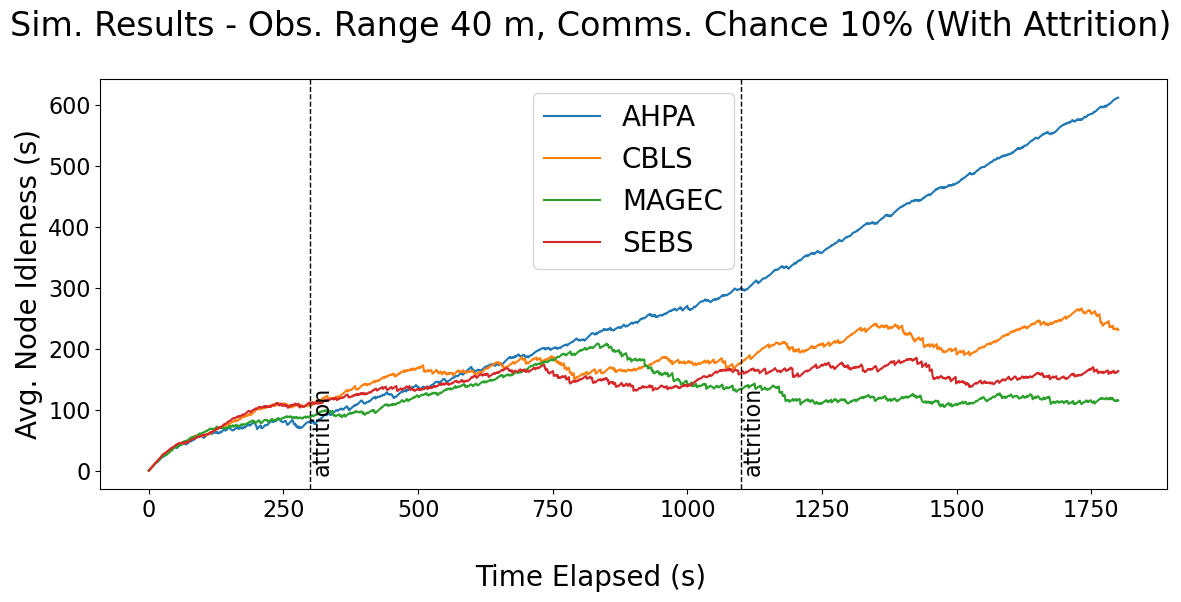

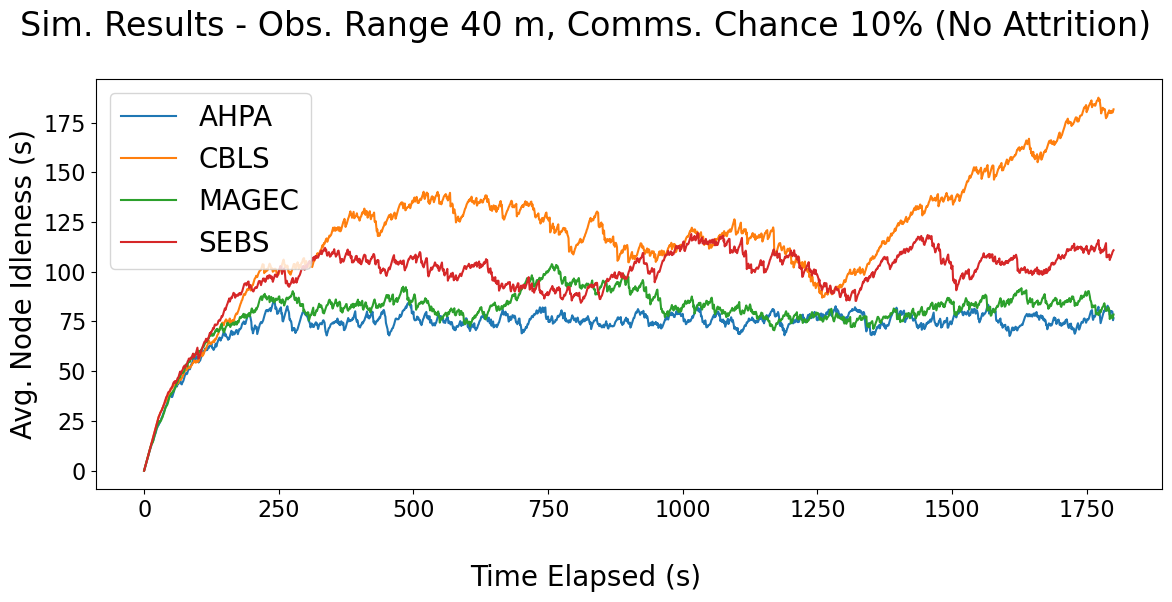

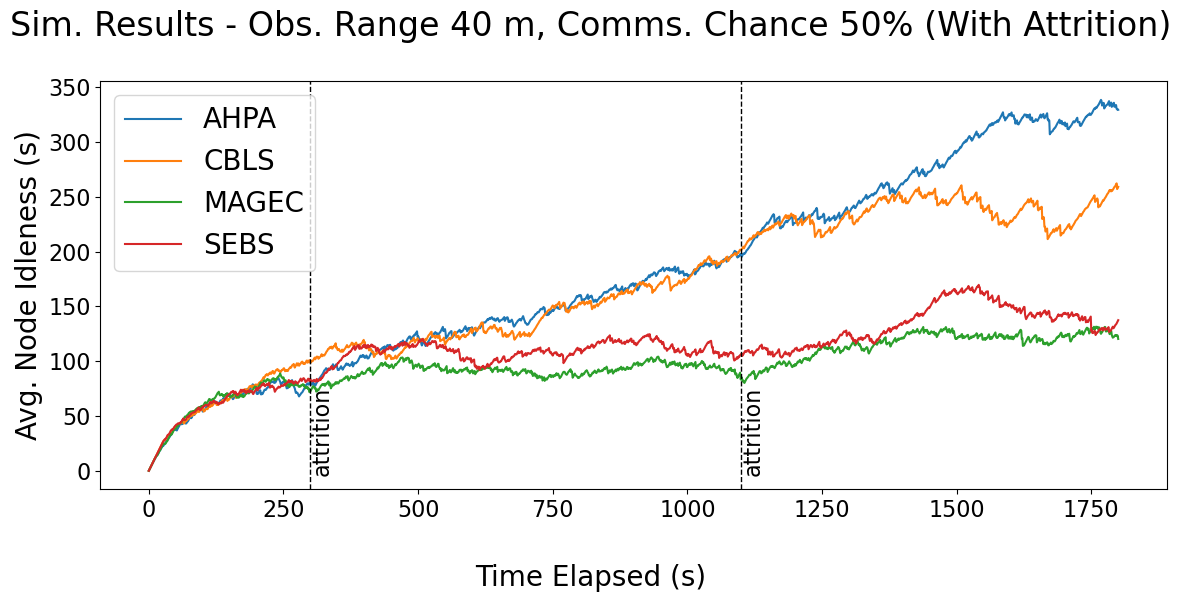

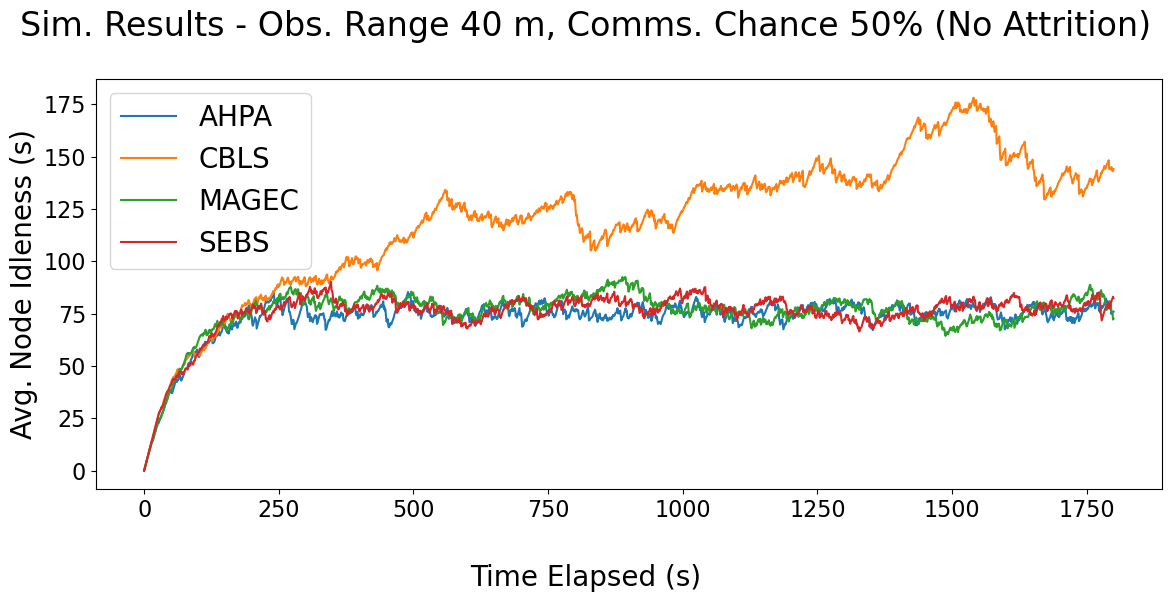

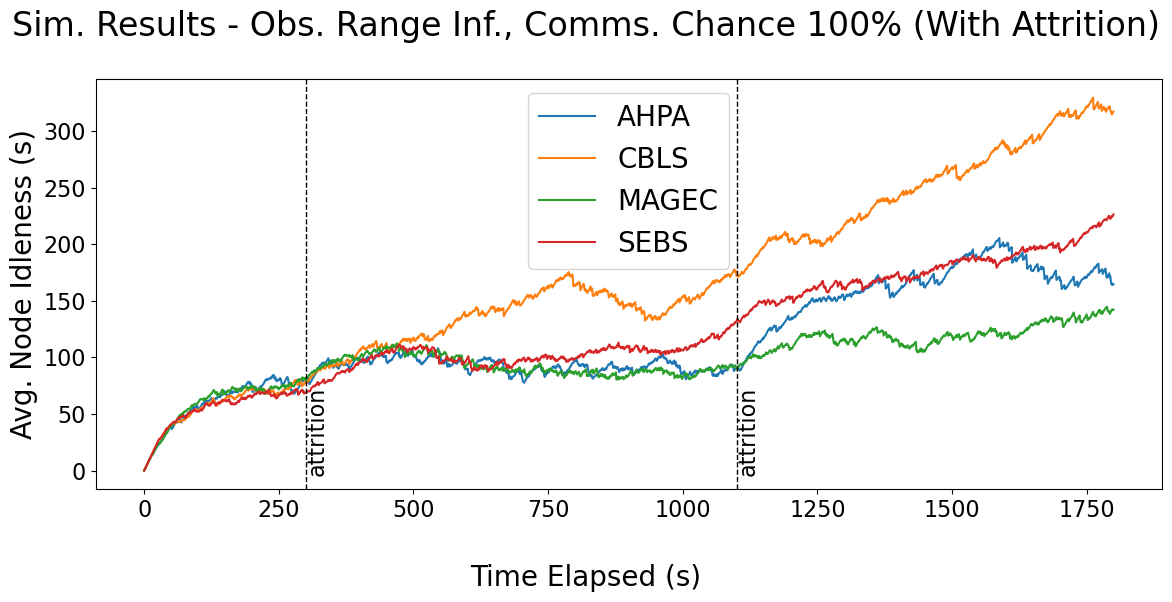

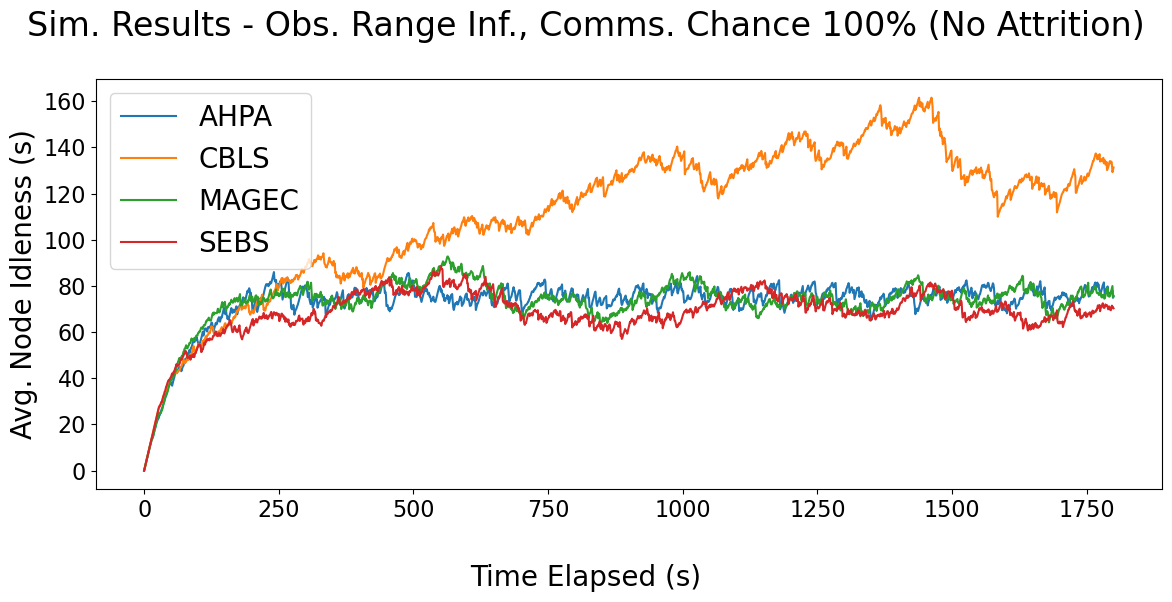

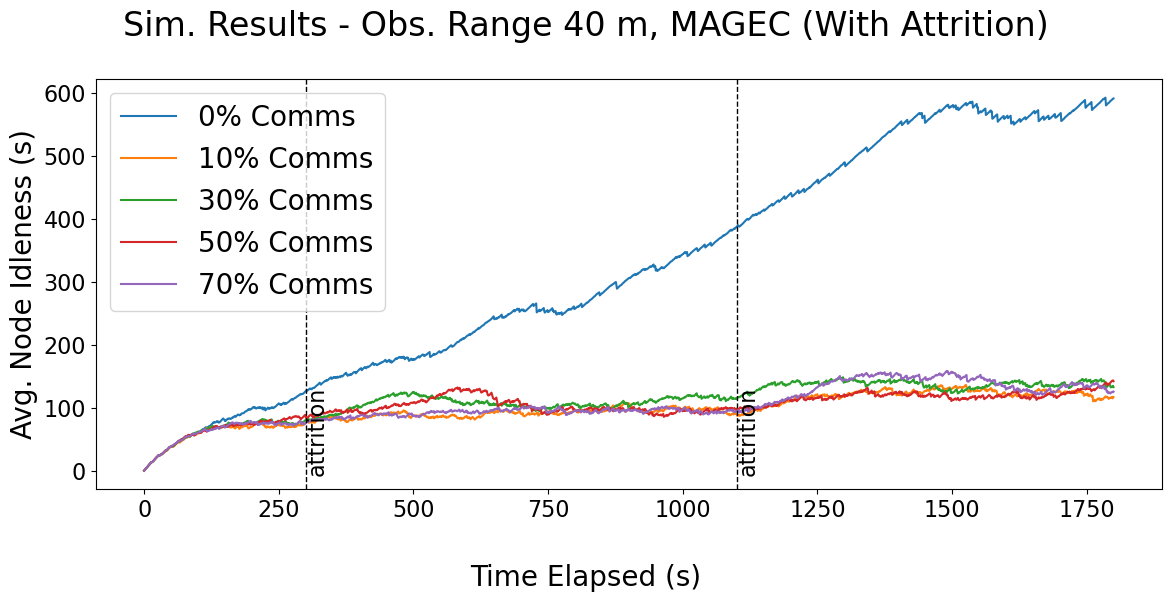

In [21]:
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_run1.zarr") # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_run1.zarr", attritionTimes=[300, 1100]) # full run of everything

# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_obs60_comms20_run1.zarr") # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_obs60_comms20_run1.zarr", attritionTimes=[300, 1100]) # full run of everything

# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_obs60_comms0_run1.zarr") # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_obs60_comms0_run1.zarr", attritionTimes=[300, 1100]) # full run of everything

# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_obsInf_comms100_run1.zarr") # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_obsInf_comms100_run1.zarr", attritionTimes=[300, 1100]) # full run of everything


# BELOW THIS IS POST-BELIEF-STATE AND POSITION RATE CHANGES:

# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_obs60_comms10_run2.zarr",) # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_obs60_comms10_run2.zarr", attritionTimes=[300, 1100]) # full run of everything

# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_obs30_comms10_run1.zarr",) # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_obs30_comms10_run1.zarr", attritionTimes=[300, 1100]) # full run of everything

# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_obs30_comms10_NERF_GBS.zarr",) # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_obs30_comms10_NERF_GBS.zarr", attritionTimes=[300, 1100]) # full run of everything

# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_no_attrition_obs30_comms10_SEBS_run1.zarr",) # full run of everything
# analyzeFile("/home/anthony/papers/iros2024/sim_results/40ky3q01_attrition_obs30_comms10_SEBS_run1.zarr", attritionTimes=[300, 1100]) # full run of everything

# NEW POLICY:
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_no_attrition_obs40_comms10_run2.zarr")
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_attrition_obs40_comms0_run1.zarr", attritionTimes=[300, 1100])

# old, using partially-trained vzsjd8ki
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_attrition_obs40_comms10_run2.zarr", attritionTimes=[300, 1100])
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_no_attrition_obs40_comms10_run2.zarr")
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_attrition_obs40_comms50_run1.zarr", attritionTimes=[300, 1100])

# new, using fully-trained vzsjd8ki
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_attrition_obs40_comms10_run3.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range 40 m, Comms. Chance 10%", title_appendAttritionLabel=True)
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_no_attrition_obs40_comms10_run3.zarr", title="Sim. Results - Obs. Range 40 m, Comms. Chance 10%", title_appendAttritionLabel=True)
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_attrition_obs40_comms50_run2.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range 40 m, Comms. Chance 50%", title_appendAttritionLabel=True)
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki_no_attrition_obs40_comms50_run1.zarr", title="Sim. Results - Obs. Range 40 m, Comms. Chance 50%", title_appendAttritionLabel=True)

# new, using partially-trained vzsjd8ki
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki-partial_attrition_obs40_comms10_run3.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range 40 m, Comms. Chance 10%", title_appendAttritionLabel=True)
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki-partial_no_attrition_obs40_comms10_run3.zarr", title="Sim. Results - Obs. Range 40 m, Comms. Chance 10%", title_appendAttritionLabel=True)
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki-partial_attrition_obs40_comms50_run2.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range 40 m, Comms. Chance 50%", title_appendAttritionLabel=True)
# analyzeFile("/home/anthony/papers/iros2024/sim_results/vzsjd8ki-partial_no_attrition_obs40_comms50_run1.zarr", title="Sim. Results - Obs. Range 40 m, Comms. Chance 50%", title_appendAttritionLabel=True)

# new, using ze1klire
analyzeFile("/home/anthony/papers/iros2024/sim_results/ze1klire_attrition_obs40_comms10_run1.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range 40 m, Comms. Chance 10%", title_appendAttritionLabel=True)
analyzeFile("/home/anthony/papers/iros2024/sim_results/ze1klire_no_attrition_obs40_comms10_run1.zarr", title="Sim. Results - Obs. Range 40 m, Comms. Chance 10%", title_appendAttritionLabel=True)
analyzeFile("/home/anthony/papers/iros2024/sim_results/ze1klire_attrition_obs40_comms50_run1.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range 40 m, Comms. Chance 50%", title_appendAttritionLabel=True)
analyzeFile("/home/anthony/papers/iros2024/sim_results/ze1klire_no_attrition_obs40_comms50_run1.zarr", title="Sim. Results - Obs. Range 40 m, Comms. Chance 50%", title_appendAttritionLabel=True)

analyzeFile("/home/anthony/papers/iros2024/sim_results/ze1klire_attrition_obsInf_comms100_run1.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range Inf., Comms. Chance 100%", title_appendAttritionLabel=True)
analyzeFile("/home/anthony/papers/iros2024/sim_results/ze1klire_no_attrition_obsInf_comms100_run1.zarr", title="Sim. Results - Obs. Range Inf., Comms. Chance 100%", title_appendAttritionLabel=True)


# abuse the system to display a handmade zarr containing multiple parameter experiments for same algorithm.
analyzeFile("/home/anthony/papers/iros2024/sim_results/ze1klire_attrition_obs40_commsComparison_run1.zarr", attritionTimes=[300, 1100], title="Sim. Results - Obs. Range 40 m, MAGEC", title_appendAttritionLabel=True)